In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# DF 불러오기

In [132]:
df0 = pd.read_csv('./after_preprocessing_data/df_final_0627.csv')

In [133]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536097 entries, 0 to 536096
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   자치구                536097 non-null  object 
 1   계약일                536097 non-null  object 
 2   건물면적(㎡)            536097 non-null  float64
 3   층                  536097 non-null  int64  
 4   KOSPI종가            536097 non-null  float64
 5   Fed기준금리            536097 non-null  float64
 6   국제유가(Dubai)($/배럴)  536097 non-null  float64
 7   부동산거래량             536097 non-null  int64  
 8   국고채5년(평균)          536097 non-null  float64
 9   국고채10년(평균)         536097 non-null  float64
 10  회사채3년(평균)          536097 non-null  float64
 11  CD91물(평균)          536097 non-null  float64
 12  BOK기준금리            536097 non-null  float64
 13  건물연식               536097 non-null  int64  
 14  GDP대비가계부채비율        536097 non-null  float64
 15  환율종가               536097 non-null  float64
 16  금값

## LTV 컬럼 추가 
- 계약일 
- 거래가격(=물건금액)
> 2가지 조건을 고려하여 LTV 값 대입 

- 서울
    - 투기과열지구 : 서울 전역 포함(17.08.02 ~ 23.01)
    - 서울 내에서 투기지역 구분 의미 X 

- 고려하지 못한 조건
    - 소득
    - 주택 소유 및 다주택 여부 
    

In [134]:
# LTV 파생변수 생성
df0['LTV'] = np.NaN

# 타입 변환
df0['계약일'] = pd.to_datetime(df0['계약일'])

df0.loc[df0['계약일'] <= '2017-06-19', 'LTV'] = 0.7

# 17.06.19 
df0.loc[(df0['계약일'] > '2017-06-19')& (df0['계약일'] <= '2017-08-02'), 'LTV'] = 0.6

# 17.08.02
df0.loc[(df0['계약일'] > '2017-08-02')&(df0['계약일'] <= '2018-09-14'), 'LTV'] = 0.4

# 18.09.13 -> 1주택 가정 
    # 서울 전체 주택보유자 비율 훨씬 높음 2:1 
    # 부동산 거래Data 중에서도 서울 APT를 사는 사람은 기존 보유주택을 팔고 온것이라 가정
# df0.loc[(df0['계약일'] > '2018-09-14')& (df0['계약일'] <= '2019-12-15'), 'LTV'] = 0.4
# df0.loc[((df0['계약일'] > '2018-09-14')& (df0['계약일'] <= '2019-12-15')) & (df0['물건금액(만원)']>90000), 'LTV'] = 0
df0.loc[(df0['계약일'] > '2018-09-14')& (df0['계약일'] <= '2019-12-16'), 'LTV'] = 0

# 19.12.16
df0.loc[(df0['계약일'] > '2019-12-16'), 'LTV'] = 0.4
df0.loc[(df0['계약일'] > '2019-12-16') & (df0['물건금액(만원)'] > 90000), 'LTV'] = 0.2
df0.loc[(df0['계약일'] > '2019-12-16') & (df0['물건금액(만원)'] > 150000), 'LTV'] = 0

In [135]:
df0['LTV'].value_counts()

0.4    214414
0.7    162023
0.0    101431
0.2     38933
0.6     19296
Name: LTV, dtype: int64

### LTV -> Label Encoding(보류)


# Train/Test Split


In [136]:
# Train : 2016-2020
# Test : 2021-2022

df0['계약일'] = pd.to_datetime(df0['계약일'])

In [137]:
train_df = df0.loc[df0['계약일'] < '2021']

In [138]:
test_df = df0.loc[df0['계약일'] >= '2021']

## feature & target split

In [139]:
# Train Split
# feature & target  split

X_train_df = train_df.drop('물건금액(만원)', axis=1)
y = train_df['물건금액(만원)']

# X_train : 숫자형 컬럼만 
X_train = X_train_df.select_dtypes([np.number])

In [140]:
# Test Split
# feature & target  split

X_test_df = test_df.drop('물건금액(만원)', axis=1)
y_test = test_df['물건금액(만원)']

# X_test : 숫자형 컬럼만 
X_test = X_test_df.select_dtypes([np.number])

---

# Scaling
1. Features - minMax
2. Target - Log 

In [141]:
# minMax
from sklearn.preprocessing import MinMaxScaler

# Scaler 객체 생성
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [142]:
# y -> log 변환

# Train
y_scaled = np.log10(y)
# y_scaled

# Test
y_test_scaled = np.log10(y_test)
y_test_scaled

453170    4.716003
453171    4.722634
453172    4.380211
453173    5.079181
453174    4.361728
            ...   
536092    5.397940
536093    5.139879
536094    5.235528
536095    4.568202
536096    4.883661
Name: 물건금액(만원), Length: 82927, dtype: float64

# OLS - Scaling 후

## OLS_1

In [143]:
# OLS_0
# 스케일링 후 predict
import statsmodels.api as sm

feature_add = sm.add_constant(X_scaled, has_constant='add')

# sm OLS 적합
model = sm.OLS(y_scaled , feature_add)
fitted_model = model.fit()

# summary 함수통해 결과출력
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               물건금액(만원)   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                 2.584e+04
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        19:21:31   Log-Likelihood:             1.3131e+05
No. Observations:              453170   AIC:                        -2.626e+05
Df Residuals:                  453150   BIC:                        -2.624e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.5791      0.008    559.029      0.000       4.563       4.595
건물면적(㎡)               2.2003      0.004    584.514      0.000       2.193       2.208
층                     0.2742      0.003     84.615      0.000       0.268       0.281
KOSPI종가               0.0259      0.006      4.084      0.000       0.013       0.038
Fed기준금리              -0.1425      0.004    -37.715      0.000      -0.150      -0.135
국제유가(Dubai)($/배럴)     0.1723      0.004     39.741      0.000       0.164       0.181
부동산거래량                0.0016      0.002      0.722      0.470      -0.003       0.006
국고채5년(평균)            -0.3747      0.020    -19.125      0.000      -0.413      -0.336
국고채10년(평균)            0.3153      0.014     22.201      0.000       0.287       0.343
회사채3년(평균)             0.1033      0.006     17.099      0.000       0.091       0.115
CD91물(평균)            -0.0879      0.009    -10.046      0.000      -0.105      -0.071
BOK기준금리              -0.0639      0.007     -8.531      0.000      -0.079      -0.049
건물연식                 -0.0050      0.002     -2.861      0.004      -0.008      -0.002
GDP대비가계부채비율          -0.0650      0.005    -12.940      0.000      -0.075      -0.055
환율종가                  0.0099      0.003      3.054      0.002       0.004       0.016
금값종가                  0.0583      0.005     12.222      0.000       0.049       0.068
선행지수순환변동치             0.1370      0.005     28.830      0.000       0.128       0.146
EPU                  -0.0075      0.002     -3.802      0.000      -0.011      -0.004
장단기금리spread          -0.2229      0.009    -24.749      0.000      -0.241      -0.205
LTV                  -0.2777      0.002   -131.009      0.000      -0.282      -0.274
==============================================================================
Omnibus:                    10921.587   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12461.300
Skew:                           0.347   Prob(JB):                         0.00
Kurtosis:                       3.421   Cond. No.                         202.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

---

In [144]:
X_scaled.drop('부동산거래량', axis=1, inplace=True)

In [145]:
# OLS_1
# 스케일링 후 predict
import statsmodels.api as sm

feature_add = sm.add_constant(X_scaled, has_constant='add')

# sm OLS 적합
model = sm.OLS(y_scaled , feature_add)
fitted_model = model.fit()

# summary 함수통해 결과출력
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               물건금액(만원)   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                 2.727e+04
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        19:21:33   Log-Likelihood:             1.3131e+05
No. Observations:              453170   AIC:                        -2.626e+05
Df Residuals:                  453151   BIC:                        -2.624e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.5781      0.008    566.153      0.000       4.562       4.594
건물면적(㎡)               2.2004      0.004    584.595      0.000       2.193       2.208
층                     0.2742      0.003     84.613      0.000       0.268       0.281
KOSPI종가               0.0271      0.006      4.432      0.000       0.015       0.039
Fed기준금리              -0.1429      0.004    -38.208      0.000      -0.150      -0.136
국제유가(Dubai)($/배럴)     0.1736      0.004     43.602      0.000       0.166       0.181
국고채5년(평균)            -0.3766      0.019    -19.390      0.000      -0.415      -0.339
국고채10년(평균)            0.3160      0.014     22.301      0.000       0.288       0.344
회사채3년(평균)             0.1019      0.006     17.797      0.000       0.091       0.113
CD91물(평균)            -0.0879      0.009    -10.047      0.000      -0.105      -0.071
BOK기준금리              -0.0636      0.007     -8.503      0.000      -0.078      -0.049
건물연식                 -0.0050      0.002     -2.872      0.004      -0.008      -0.002
GDP대비가계부채비율          -0.0652      0.005    -12.998      0.000      -0.075      -0.055
환율종가                  0.0099      0.003      3.068      0.002       0.004       0.016
금값종가                  0.0600      0.004     14.367      0.000       0.052       0.068
선행지수순환변동치             0.1366      0.005     28.882      0.000       0.127       0.146
EPU                  -0.0078      0.002     -4.000      0.000      -0.012      -0.004
장단기금리spread          -0.2210      0.009    -25.686      0.000      -0.238      -0.204
LTV                  -0.2774      0.002   -133.806      0.000      -0.281      -0.273
==============================================================================
Omnibus:                    10916.452   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12454.891
Skew:                           0.347   Prob(JB):                         0.00
Kurtosis:                       3.421   Cond. No.                         197.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [146]:
# VIF_1
from statsmodels.stats.outliers_influence import variance_inflation_factor

def feature_engineering_XbyVIF(X_scaled):
    vif = pd.DataFrame()
    vif["VIF_Factor"] = [variance_inflation_factor(X_scaled.values,i)
                         for i in range(X_scaled.shape[1])]
    vif["Feature"] = X_scaled.columns
    return vif


In [147]:
vif = feature_engineering_XbyVIF(X_scaled)
print(vif)

     VIF_Factor            Feature
0      6.309358            건물면적(㎡)
1      5.095493                  층
2    126.783942            KOSPI종가
3     50.391298            Fed기준금리
4     76.625107  국제유가(Dubai)($/배럴)
5   1155.573691          국고채5년(평균)
6    793.073506         국고채10년(평균)
7    120.525879          회사채3년(평균)
8    329.697449          CD91물(평균)
9    272.098273            BOK기준금리
10     5.607387               건물연식
11    64.608910        GDP대비가계부채비율
12    28.954342               환율종가
13    20.740890               금값종가
14   120.430659          선행지수순환변동치
15     5.309569                EPU
16   190.661625        장단기금리spread
17    26.511475                LTV


In [148]:
X_scaled.drop('국고채5년(평균)', axis=1, inplace=True)

In [149]:
# OLS_2
# 스케일링 후 predict
import statsmodels.api as sm

feature_add = sm.add_constant(X_scaled, has_constant='add')

# sm OLS 적합
model = sm.OLS(y_scaled , feature_add)
fitted_model = model.fit()

# summary 함수통해 결과출력
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               물건금액(만원)   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                 2.883e+04
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        19:21:57   Log-Likelihood:             1.3112e+05
No. Observations:              453170   AIC:                        -2.622e+05
Df Residuals:                  453152   BIC:                        -2.620e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.6461      0.007    637.338      0.000       4.632       4.660
건물면적(㎡)               2.2010      0.004    584.560      0.000       2.194       2.208
층                     0.2740      0.003     84.514      0.000       0.268       0.280
KOSPI종가               0.0170      0.006      2.793      0.005       0.005       0.029
Fed기준금리              -0.1555      0.004    -42.188      0.000      -0.163      -0.148
국제유가(Dubai)($/배럴)     0.1718      0.004     43.149      0.000       0.164       0.180
국고채10년(평균)            0.0982      0.009     11.364      0.000       0.081       0.115
회사채3년(평균)             0.0697      0.005     12.710      0.000       0.059       0.080
CD91물(평균)            -0.1405      0.008    -16.895      0.000      -0.157      -0.124
BOK기준금리              -0.1300      0.007    -19.547      0.000      -0.143      -0.117
건물연식                 -0.0047      0.002     -2.695      0.007      -0.008      -0.001
GDP대비가계부채비율          -0.0471      0.005     -9.563      0.000      -0.057      -0.037
환율종가                  0.0353      0.003     11.897      0.000       0.029       0.041
금값종가                  0.0495      0.004     11.958      0.000       0.041       0.058
선행지수순환변동치             0.1469      0.005     31.243      0.000       0.138       0.156
EPU                  -0.0172      0.002     -9.150      0.000      -0.021      -0.014
장단기금리spread          -0.3292      0.007    -50.270      0.000      -0.342      -0.316
LTV                  -0.2700      0.002   -132.447      0.000      -0.274      -0.266
==============================================================================
Omnibus:                    10994.415   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12519.811
Skew:                           0.350   Prob(JB):                         0.00
Kurtosis:                       3.417   Cond. No.                         102.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [150]:
# VIF_2
vif = feature_engineering_XbyVIF(X_scaled)
print(vif)

    VIF_Factor            Feature
0     6.275346            건물면적(㎡)
1     5.088570                  층
2   125.116490            KOSPI종가
3    46.351649            Fed기준금리
4    76.601642  국제유가(Dubai)($/배럴)
5   231.012772         국고채10년(평균)
6   111.416431          회사채3년(평균)
7   326.098930          CD91물(평균)
8   242.675948            BOK기준금리
9     5.595296               건물연식
10   54.052368        GDP대비가계부채비율
11   19.616717               환율종가
12   20.563182               금값종가
13  117.794389          선행지수순환변동치
14    5.182175                EPU
15  135.929816        장단기금리spread
16   22.210734                LTV


In [151]:
X_scaled.drop('CD91물(평균)', axis=1, inplace=True)

In [152]:
# OLS_3
# 스케일링 후 predict
import statsmodels.api as sm

feature_add = sm.add_constant(X_scaled, has_constant='add')

# sm OLS 적합
model = sm.OLS(y_scaled , feature_add)
fitted_model = model.fit()

# summary 함수통해 결과출력
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               물건금액(만원)   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                 3.059e+04
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        19:22:18   Log-Likelihood:             1.3098e+05
No. Observations:              453170   AIC:                        -2.619e+05
Df Residuals:                  453153   BIC:                        -2.617e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.5889      0.006    710.478      0.000       4.576       4.602
건물면적(㎡)               2.2020      0.004    584.699      0.000       2.195       2.209
층                     0.2740      0.003     84.502      0.000       0.268       0.280
KOSPI종가               0.0423      0.006      7.150      0.000       0.031       0.054
Fed기준금리              -0.1587      0.004    -43.100      0.000      -0.166      -0.151
국제유가(Dubai)($/배럴)     0.1615      0.004     41.042      0.000       0.154       0.169
국고채10년(평균)            0.0098      0.007      1.420      0.156      -0.004       0.023
회사채3년(평균)             0.1039      0.005     20.375      0.000       0.094       0.114
BOK기준금리              -0.1950      0.005    -35.944      0.000      -0.206      -0.184
건물연식                 -0.0046      0.002     -2.641      0.008      -0.008      -0.001
GDP대비가계부채비율          -0.0366      0.005     -7.493      0.000      -0.046      -0.027
환율종가                  0.0446      0.003     15.276      0.000       0.039       0.050
금값종가                  0.0250      0.004      6.442      0.000       0.017       0.033
선행지수순환변동치             0.1677      0.005     36.944      0.000       0.159       0.177
EPU                  -0.0170      0.002     -9.062      0.000      -0.021      -0.013
장단기금리spread          -0.3023      0.006    -47.575      0.000      -0.315      -0.290
LTV                  -0.2681      0.002   -131.686      0.000      -0.272      -0.264
==============================================================================
Omnibus:                    11113.972   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12662.561
Skew:                           0.352   Prob(JB):                         0.00
Kurtosis:                       3.418   Cond. No.                         77.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [153]:
X_scaled.drop('국고채10년(평균)', axis=1, inplace=True)

In [154]:
# OLS_4
# 스케일링 후 predict
import statsmodels.api as sm

feature_add = sm.add_constant(X_scaled, has_constant='add')

# sm OLS 적합
model = sm.OLS(y_scaled , feature_add)
fitted_model = model.fit()

# summary 함수통해 결과출력
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               물건금액(만원)   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                 3.263e+04
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        19:22:19   Log-Likelihood:             1.3097e+05
No. Observations:              453170   AIC:                        -2.619e+05
Df Residuals:                  453154   BIC:                        -2.617e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.5865      0.006    737.368      0.000       4.574       4.599
건물면적(㎡)               2.2020      0.004    584.698      0.000       2.195       2.209
층                     0.2740      0.003     84.501      0.000       0.268       0.280
KOSPI종가               0.0408      0.006      7.009      0.000       0.029       0.052
Fed기준금리              -0.1578      0.004    -43.529      0.000      -0.165      -0.151
국제유가(Dubai)($/배럴)     0.1619      0.004     41.221      0.000       0.154       0.170
회사채3년(평균)             0.1085      0.004     27.597      0.000       0.101       0.116
BOK기준금리              -0.1924      0.005    -37.720      0.000      -0.202      -0.182
건물연식                 -0.0046      0.002     -2.621      0.009      -0.008      -0.001
GDP대비가계부채비율          -0.0379      0.005     -7.898      0.000      -0.047      -0.029
환율종가                  0.0451      0.003     15.588      0.000       0.039       0.051
금값종가                  0.0260      0.004      6.809      0.000       0.019       0.033
선행지수순환변동치             0.1711      0.004     44.046      0.000       0.163       0.179
EPU                  -0.0166      0.002     -8.951      0.000      -0.020      -0.013
장단기금리spread          -0.2995      0.006    -49.627      0.000      -0.311      -0.288
LTV                  -0.2679      0.002   -131.889      0.000      -0.272      -0.264
==============================================================================
Omnibus:                    11114.899   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12663.365
Skew:                           0.352   Prob(JB):                         0.00
Kurtosis:                       3.418   Cond. No.                         74.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [155]:
# VIF_4
vif = feature_engineering_XbyVIF(X_scaled)
print(vif)

    VIF_Factor            Feature
0     6.235570            건물면적(㎡)
1     5.072690                  층
2   112.857062            KOSPI종가
3    42.365863            Fed기준금리
4    74.097837  국제유가(Dubai)($/배럴)
5    39.434496          회사채3년(평균)
6    62.235236            BOK기준금리
7     5.584190               건물연식
8    45.291615        GDP대비가계부채비율
9    19.568532               환율종가
10   16.597576               금값종가
11   78.366665          선행지수순환변동치
12    5.090947                EPU
13  129.767697        장단기금리spread
14   20.884089                LTV


In [156]:
# # 각 숫자형 변수들의 피어슨 상관 분포를 히트맵으로 출력
# def plot_cor(df):

#     df_ = df.select_dtypes(include=[np.number])
#     df_cor = df_.corr(method='pearson')
#     plt.figure(figsize = (15, 15))
#     plt.rc('font', family = 'Malgun Gothic')
#     sns.heatmap(df_cor, 
#                 xticklabels = df_cor.columns, 
#                 yticklabels = df_cor.columns, 
#                 cmap = 'coolwarm', 
#                 annot = True,
#                 annot_kws = {'size':10}, 
#                 linewidth = 3,
#                 vmin=-1, vmax=1)

In [157]:
# plot_cor(X_scaled)

In [158]:
X_scaled.drop('장단기금리spread', axis=1, inplace=True)

In [159]:
# OLS_5
# 스케일링 후 predict
import statsmodels.api as sm

feature_add = sm.add_constant(X_scaled, has_constant='add')

# sm OLS 적합
model = sm.OLS(y_scaled , feature_add)
fitted_model = model.fit()

# summary 함수통해 결과출력
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               물건금액(만원)   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                 3.460e+04
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        19:22:34   Log-Likelihood:             1.2975e+05
No. Observations:              453170   AIC:                        -2.595e+05
Df Residuals:                  453155   BIC:                        -2.593e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.4430      0.006    804.510      0.000       4.432       4.454
건물면적(㎡)               2.2084      0.004    585.160      0.000       2.201       2.216
층                     0.2759      0.003     84.849      0.000       0.270       0.282
KOSPI종가               0.1208      0.006     21.554      0.000       0.110       0.132
Fed기준금리              -0.1283      0.004    -35.776      0.000      -0.135      -0.121
국제유가(Dubai)($/배럴)     0.0816      0.004     22.729      0.000       0.075       0.089
회사채3년(평균)            -0.0565      0.002    -26.842      0.000      -0.061      -0.052
BOK기준금리              -0.0618      0.004    -14.106      0.000      -0.070      -0.053
건물연식                 -0.0037      0.002     -2.141      0.032      -0.007      -0.000
GDP대비가계부채비율           0.0268      0.005      5.782      0.000       0.018       0.036
환율종가                  0.0534      0.003     18.447      0.000       0.048       0.059
금값종가                  0.0009      0.004      0.224      0.823      -0.007       0.008
선행지수순환변동치             0.0391      0.003     13.782      0.000       0.034       0.045
EPU                  -0.0170      0.002     -9.116      0.000      -0.021      -0.013
LTV                  -0.2380      0.002   -122.357      0.000      -0.242      -0.234
==============================================================================
Omnibus:                    11541.178   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13110.834
Skew:                           0.362   Prob(JB):                         0.00
Kurtosis:                       3.413   Cond. No.                         57.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [160]:
X_scaled.drop('금값종가', axis=1, inplace=True)

In [161]:
# VIF_5
vif = feature_engineering_XbyVIF(X_scaled)
print(vif)

    VIF_Factor            Feature
0     6.200003            건물면적(㎡)
1     5.053635                  층
2   111.009567            KOSPI종가
3    33.049649            Fed기준금리
4    49.994118  국제유가(Dubai)($/배럴)
5     9.477026          회사채3년(평균)
6    56.681025            BOK기준금리
7     5.563291               건물연식
8    40.110602        GDP대비가계부채비율
9    16.049712               환율종가
10   36.755819          선행지수순환변동치
11    4.821709                EPU
12   19.806007                LTV


In [162]:
# plot_cor(X_scaled)

In [163]:
X_scaled.drop('KOSPI종가', axis=1, inplace=True)

In [164]:
# OLS_6
# 스케일링 후 predict
import statsmodels.api as sm

feature_add = sm.add_constant(X_scaled, has_constant='add')

# sm OLS 적합
model = sm.OLS(y_scaled , feature_add)
fitted_model = model.fit()

# summary 함수통해 결과출력
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               물건금액(만원)   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                 4.028e+04
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        19:22:46   Log-Likelihood:             1.2951e+05
No. Observations:              453170   AIC:                        -2.590e+05
Df Residuals:                  453157   BIC:                        -2.588e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.4789      0.005    903.415      0.000       4.469       4.489
건물면적(㎡)               2.2077      0.004    584.686      0.000       2.200       2.215
층                     0.2760      0.003     84.840      0.000       0.270       0.282
Fed기준금리              -0.1333      0.003    -40.247      0.000      -0.140      -0.127
국제유가(Dubai)($/배럴)     0.0807      0.003     24.311      0.000       0.074       0.087
회사채3년(평균)            -0.0498      0.002    -30.949      0.000      -0.053      -0.047
BOK기준금리              -0.0513      0.004    -11.918      0.000      -0.060      -0.043
건물연식                 -0.0036      0.002     -2.043      0.041      -0.007      -0.000
GDP대비가계부채비율           0.0686      0.004     16.322      0.000       0.060       0.077
환율종가                  0.0313      0.003     11.724      0.000       0.026       0.036
선행지수순환변동치             0.0765      0.002     38.444      0.000       0.073       0.080
EPU                  -0.0243      0.002    -13.708      0.000      -0.028      -0.021
LTV                  -0.2454      0.002   -128.054      0.000      -0.249      -0.242
==============================================================================
Omnibus:                    11381.610   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12925.617
Skew:                           0.359   Prob(JB):                         0.00
Kurtosis:                       3.412   Cond. No.                         52.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [165]:
# VIF_6
vif = feature_engineering_XbyVIF(X_scaled)
print(vif)

    VIF_Factor            Feature
0     6.184198            건물면적(㎡)
1     5.044680                  층
2    31.113854            Fed기준금리
3    49.743125  국제유가(Dubai)($/배럴)
4     9.323822          회사채3년(평균)
5    42.940625            BOK기준금리
6     5.553387               건물연식
7    15.407385        GDP대비가계부채비율
8    15.190862               환율종가
9    17.736784          선행지수순환변동치
10    4.709221                EPU
11   19.798161                LTV


In [166]:
X_scaled.drop('국제유가(Dubai)($/배럴)', axis=1, inplace=True)

In [167]:
# OLS_7
# 스케일링 후 predict
import statsmodels.api as sm

feature_add = sm.add_constant(X_scaled, has_constant='add')

# sm OLS 적합
model = sm.OLS(y_scaled , feature_add)
fitted_model = model.fit()

# summary 함수통해 결과출력
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               물건금액(만원)   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                 4.384e+04
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        19:22:55   Log-Likelihood:             1.2921e+05
No. Observations:              453170   AIC:                        -2.584e+05
Df Residuals:                  453158   BIC:                        -2.583e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.5084      0.005    937.147      0.000       4.499       4.518
건물면적(㎡)         2.2099      0.004    585.062      0.000       2.202       2.217
층               0.2759      0.003     84.744      0.000       0.270       0.282
Fed기준금리        -0.0893      0.003    -32.175      0.000      -0.095      -0.084
회사채3년(평균)      -0.0386      0.002    -25.018      0.000      -0.042      -0.036
BOK기준금리        -0.0547      0.004    -12.719      0.000      -0.063      -0.046
건물연식           -0.0039      0.002     -2.240      0.025      -0.007      -0.000
GDP대비가계부채비율     0.0768      0.004     18.314      0.000       0.069       0.085
환율종가            0.0021      0.002      0.890      0.373      -0.003       0.007
선행지수순환변동치       0.0714      0.002     36.050      0.000       0.068       0.075
EPU            -0.0143      0.002     -8.320      0.000      -0.018      -0.011
LTV            -0.2406      0.002   -126.136      0.000      -0.244      -0.237
==============================================================================
Omnibus:                    11453.523   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13003.623
Skew:                           0.360   Prob(JB):                         0.00
Kurtosis:                       3.411   Cond. No.                         49.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [168]:
X_scaled.drop('환율종가', axis=1, inplace=True)

In [169]:
# OLS_8
# 스케일링 후 predict
import statsmodels.api as sm

feature_add = sm.add_constant(X_scaled, has_constant='add')

# sm OLS 적합
model = sm.OLS(y_scaled , feature_add)
fitted_model = model.fit()

# summary 함수통해 결과출력
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               물건금액(만원)   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                 4.822e+04
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        19:22:56   Log-Likelihood:             1.2921e+05
No. Observations:              453170   AIC:                        -2.584e+05
Df Residuals:                  453159   BIC:                        -2.583e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.5103      0.004   1054.781      0.000       4.502       4.519
건물면적(㎡)         2.2098      0.004    585.083      0.000       2.202       2.217
층               0.2759      0.003     84.753      0.000       0.270       0.282
Fed기준금리        -0.0890      0.003    -32.327      0.000      -0.094      -0.084
회사채3년(평균)      -0.0386      0.002    -25.025      0.000      -0.042      -0.036
BOK기준금리        -0.0556      0.004    -13.339      0.000      -0.064      -0.047
건물연식           -0.0039      0.002     -2.224      0.026      -0.007      -0.000
GDP대비가계부채비율     0.0762      0.004     18.451      0.000       0.068       0.084
선행지수순환변동치       0.0705      0.002     42.570      0.000       0.067       0.074
EPU            -0.0140      0.002     -8.346      0.000      -0.017      -0.011
LTV            -0.2405      0.002   -126.181      0.000      -0.244      -0.237
==============================================================================
Omnibus:                    11452.834   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13002.016
Skew:                           0.360   Prob(JB):                         0.00
Kurtosis:                       3.411   Cond. No.                         45.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [170]:
# VIF_8
vif = feature_engineering_XbyVIF(X_scaled)
print(vif)

   VIF_Factor      Feature
0    6.098258      건물면적(㎡)
1    5.009032            층
2   23.046000      Fed기준금리
3    8.665489    회사채3년(평균)
4   37.857383      BOK기준금리
5    5.510656         건물연식
6    7.564838  GDP대비가계부채비율
7   14.106923    선행지수순환변동치
8    3.897658          EPU
9   16.018550          LTV


In [171]:
X_scaled.drop('BOK기준금리', axis=1, inplace=True)

In [172]:
# OLS_9
# 스케일링 후 predict
import statsmodels.api as sm

feature_add = sm.add_constant(X_scaled, has_constant='add')

# sm OLS 적합
model = sm.OLS(y_scaled , feature_add)
fitted_model = model.fit()

# summary 함수통해 결과출력
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               물건금액(만원)   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                 5.354e+04
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        19:23:01   Log-Likelihood:             1.2912e+05
No. Observations:              453170   AIC:                        -2.582e+05
Df Residuals:                  453160   BIC:                        -2.581e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.4648      0.003   1734.248      0.000       4.460       4.470
건물면적(㎡)         2.2116      0.004    585.765      0.000       2.204       2.219
층               0.2762      0.003     84.839      0.000       0.270       0.283
Fed기준금리        -0.1191      0.002    -75.468      0.000      -0.122      -0.116
회사채3년(평균)      -0.0419      0.002    -27.496      0.000      -0.045      -0.039
건물연식           -0.0040      0.002     -2.270      0.023      -0.007      -0.001
GDP대비가계부채비율     0.1247      0.002     64.217      0.000       0.121       0.129
선행지수순환변동치       0.0760      0.002     47.400      0.000       0.073       0.079
EPU            -0.0112      0.002     -6.737      0.000      -0.014      -0.008
LTV            -0.2356      0.002   -125.945      0.000      -0.239      -0.232
==============================================================================
Omnibus:                    11505.341   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13082.432
Skew:                           0.361   Prob(JB):                         0.00
Kurtosis:                       3.415   Cond. No.                         23.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [173]:
# VIF_9
vif = feature_engineering_XbyVIF(X_scaled)
print(vif)

   VIF_Factor      Feature
0    5.751902      건물면적(㎡)
1    4.820542            층
2    4.878149      Fed기준금리
3    8.502950    회사채3년(평균)
4    5.279798         건물연식
5    4.595034  GDP대비가계부채비율
6   13.716676    선행지수순환변동치
7    3.781902          EPU
8    9.960467          LTV


In [174]:
X_scaled.drop('선행지수순환변동치', axis=1, inplace=True)

In [175]:
# OLS_10
# 스케일링 후 predict
import statsmodels.api as sm

feature_add = sm.add_constant(X_scaled, has_constant='add')

# sm OLS 적합
model = sm.OLS(y_scaled , feature_add)
fitted_model = model.fit()

# summary 함수통해 결과출력
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               물건금액(만원)   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                 5.965e+04
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        19:23:06   Log-Likelihood:             1.2800e+05
No. Observations:              453170   AIC:                        -2.560e+05
Df Residuals:                  453161   BIC:                        -2.559e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.4628      0.003   1729.420      0.000       4.458       4.468
건물면적(㎡)         2.2219      0.004    588.024      0.000       2.214       2.229
층               0.2788      0.003     85.426      0.000       0.272       0.285
Fed기준금리        -0.1053      0.002    -67.722      0.000      -0.108      -0.102
회사채3년(평균)       0.0015      0.001      1.233      0.218      -0.001       0.004
건물연식           -0.0066      0.002     -3.774      0.000      -0.010      -0.003
GDP대비가계부채비율     0.1208      0.002     62.064      0.000       0.117       0.125
EPU            -0.0297      0.002    -18.322      0.000      -0.033      -0.027
LTV            -0.1967      0.002   -116.722      0.000      -0.200      -0.193
==============================================================================
Omnibus:                    11632.748   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13199.935
Skew:                           0.364   Prob(JB):                         0.00
Kurtosis:                       3.410   Cond. No.                         22.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [176]:
X_scaled.drop('회사채3년(평균)', axis=1, inplace=True)

In [177]:
# VIF_10
vif = feature_engineering_XbyVIF(X_scaled)
print(vif)

   VIF_Factor      Feature
0    5.719108      건물면적(㎡)
1    4.818483            층
2    3.162496      Fed기준금리
3    5.272473         건물연식
4    3.820013  GDP대비가계부채비율
5    2.633004          EPU
6    4.469027          LTV


In [185]:
# OLS_11
# 스케일링 후 predict
import statsmodels.api as sm

feature_add = sm.add_constant(X_scaled, has_constant='add')

# sm OLS 적합
model = sm.OLS(y_scaled , feature_add)
fitted_model = model.fit()

# summary 함수통해 결과출력
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               물건금액(만원)   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                 6.817e+04
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        19:30:02   Log-Likelihood:             1.2800e+05
No. Observations:              453170   AIC:                        -2.560e+05
Df Residuals:                  453162   BIC:                        -2.559e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.4629      0.003   1731.794      0.000       4.458       4.468
건물면적(㎡)         2.2220      0.004    588.373      0.000       2.215       2.229
층               0.2788      0.003     85.430      0.000       0.272       0.285
Fed기준금리        -0.1046      0.001    -72.311      0.000      -0.107      -0.102
건물연식           -0.0066      0.002     -3.789      0.000      -0.010      -0.003
GDP대비가계부채비율     0.1213      0.002     63.896      0.000       0.118       0.125
EPU            -0.0307      0.001    -21.811      0.000      -0.033      -0.028
LTV            -0.1963      0.002   -118.553      0.000      -0.200      -0.193
==============================================================================
Omnibus:                    11640.120   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13209.896
Skew:                           0.364   Prob(JB):                         0.00
Kurtosis:                       3.410   Cond. No.                         21.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

---

# 요약 
>_______OLS____________________________________VIF
1. 국채5년&10년 _________________________ CD
2. _____________________________________ 회사채 3년 (Heatmap)
3. _____________________________________ KOSPI 종가 
4. 금값종가 _____________________________ 국제유가
5. 기준금리&선행지수순환변동치

# Train LinearReression
- Train 최종에서 선형회귀 교차검증(CV)

In [178]:
# 교차 검증 수행
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

mlr = LinearRegression()

cross_val_scores = cross_val_score(mlr, X_scaled, y_scaled, scoring='neg_mean_squared_error', cv=5)
cross_val_rmse_scores = np.sqrt(-cross_val_scores)
avg_cross_val_rmse = np.mean(cross_val_rmse_scores)
print('Average Cross-Validated RMSE: {:.3f}'.format(avg_cross_val_rmse))
print(f'교차검증별 MSE : {np.round(-cross_val_scores,4)}')
print(f'교차검증 평균 MSE : {np.round(np.mean(-cross_val_scores),5)}')

Average Cross-Validated RMSE: 0.189
교차검증별 MSE : [0.0289 0.0315 0.0332 0.0459 0.0397]
교차검증 평균 MSE : 0.03585


# Test Set

## Test 컬럼 제거 
- Train OLS 에서 삭제한 컬럼 동일하게 Test도 제거 


In [179]:
X_scaled.columns

Index(['건물면적(㎡)', '층', 'Fed기준금리', '건물연식', 'GDP대비가계부채비율', 'EPU', 'LTV'], dtype='object')

In [180]:
X_train.columns 

Index(['건물면적(㎡)', '층', 'KOSPI종가', 'Fed기준금리', '국제유가(Dubai)($/배럴)', '부동산거래량',
       '국고채5년(평균)', '국고채10년(평균)', '회사채3년(평균)', 'CD91물(평균)', 'BOK기준금리', '건물연식',
       'GDP대비가계부채비율', '환율종가', '금값종가', '선행지수순환변동치', 'EPU', '장단기금리spread',
       'LTV'],
      dtype='object')

In [181]:
X_test_scaled.drop(['KOSPI종가', '국제유가(Dubai)($/배럴)', '부동산거래량',
       '국고채5년(평균)', '국고채10년(평균)', '회사채3년(평균)', 'CD91물(평균)', 'BOK기준금리',
       '환율종가', '금값종가', '선행지수순환변동치','장단기금리spread',
       ], axis=1, inplace=True)

In [182]:
X_scaled

,건물면적(㎡),층,Fed기준금리,건물연식,GDP대비가계부채비율,EPU,LTV
0,0.072266,0.180556,0.122363,0.442623,0.0,0.403866,1.000000
1,0.157736,0.180556,0.122363,0.459016,0.0,0.403866,1.000000
2,0.180570,0.083333,0.122363,0.262295,0.0,0.403866,1.000000
3,0.221941,0.166667,0.122363,0.131148,0.0,0.403866,1.000000
4,0.179990,0.180556,0.122363,0.459016,0.0,0.403866,1.000000
...,...,...,...,...,...,...,...
453165,0.179290,0.083333,0.016878,0.098361,1.0,0.181199,0.000000
453166,0.120589,0.069444,0.016878,0.344262,1.0,0.181199,0.571429
453167,0.179073,0.138889,0.016878,0.180328,1.0,0.181199,0.000000
453168,0.180232,0.055556,0.016878,0.295082,1.0,0.181199,0.571429


In [183]:
X_test_scaled

,건물면적(㎡),층,Fed기준금리,건물연식,GDP대비가계부채비율,EPU,LTV
0,0.110813,0.125000,0.016878,0.344262,1.022617,0.249647,0.571429
1,0.096476,0.138889,0.016878,0.377049,1.022617,0.249647,0.571429
2,0.007241,0.250000,0.016878,0.049180,1.022617,0.249647,0.571429
3,0.120468,0.388889,0.016878,0.163934,1.022617,0.249647,0.285714
4,0.007241,0.138889,0.016878,0.049180,1.022617,0.249647,0.571429
...,...,...,...,...,...,...,...
82922,0.343495,0.166667,1.708861,0.327869,1.051696,0.379929,0.000000
82923,0.180280,0.194444,1.708861,0.590164,1.051696,0.379929,0.285714
82924,0.180739,0.375000,1.708861,0.262295,1.051696,0.379929,0.000000
82925,0.130340,0.111111,1.708861,0.459016,1.051696,0.379929,0.571429


## Test -> Linear Regression

In [184]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, r2_score

mlr = LinearRegression()

# 모델을 훈련하고 교차 검증을 수행
cv_results = cross_validate(mlr, X_scaled, y_scaled, cv=5, return_estimator=True)

# 교차 검증 결과에서 각 폴드에서 훈련된 모델을 가져옴
trained_models = cv_results['estimator']
# 각 폴드에서 훈련된 모델을 테스트 데이터에 적용
for model in trained_models:
    y_pred = model.predict(X_test_scaled)
    # 예측 결과를 활용하여 원하는 작업을 수행
    mse = mean_squared_error(y_test_scaled, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_scaled,y_pred)
    print('MSE : {0:}, RMSE : {1: .3f}, MAE:{1: .3f}'.format(mse, rmse, mae))
    print('Variance score : {0: .3f}'.format(r2_score(y_test_scaled, y_pred)))
    print('\n')

MSE : 0.04476295339641849, RMSE :  0.212, MAE: 0.212
Variance score :  0.634


MSE : 0.04327544040339687, RMSE :  0.208, MAE: 0.208
Variance score :  0.646


MSE : 0.04413652330236122, RMSE :  0.210, MAE: 0.210
Variance score :  0.639


MSE : 0.04205960043253851, RMSE :  0.205, MAE: 0.205
Variance score :  0.656


MSE : 0.05909674654194256, RMSE :  0.243, MAE: 0.243
Variance score :  0.517




In [186]:
from sklearn.model_selection import cross_validate

y_pred = trained_models[3].predict(X_test_scaled)

mse = mean_squared_error(y_test_scaled, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_scaled,y_pred)

print('MSE : {0:}, RMSE : {1: .3f}, MAE:{1: .3f}'.format(mse, rmse, mae))
print('Variance score : {0: .3f}'.format(r2_score(y_test_scaled, y_pred)))

MSE : 0.04205960043253851, RMSE :  0.205, MAE: 0.205
Variance score :  0.656


In [188]:
# test 계수 결과 DF 

test_result = pd.DataFrame(data= X_test_scaled.columns)
test_result.columns = ['features']

test_result['coefficient'] = trained_models[3].coef_

test_result.sort_values('coefficient', ascending=False)

,features,coefficient
0,건물면적(㎡),2.163402
1,층,0.257289
4,GDP대비가계부채비율,0.056376
3,건물연식,-0.001912
5,EPU,-0.020882
2,Fed기준금리,-0.121529
6,LTV,-0.280674


In [196]:
X_train['LTV'].describe()

count    453170.000000
mean          0.430367
std           0.256001
min           0.000000
25%           0.400000
50%           0.400000
75%           0.700000
max           0.700000
Name: LTV, dtype: float64

> 회귀 계수 해석 주의 


# 잔차항 검정 
1. 정규성
2. 등분산성
3. 독립성

In [189]:
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats

import seaborn as sns

import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Malgun Gothic'  # windows
# matplotlib.rcParams['font.family'] = 'AppleGothic'  # Mac
matplotlib.rcParams['font.size'] = 15  # 글자크기
matplotlib.rcParams['axes.unicode_minus'] = False # 한글 폰트 사용시 마이너스 꺠지지않게 해줌

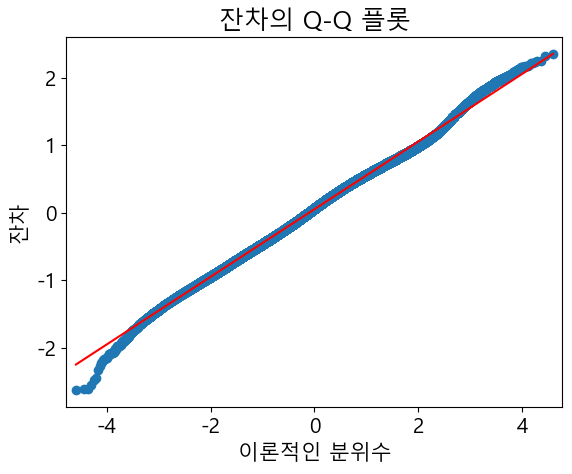

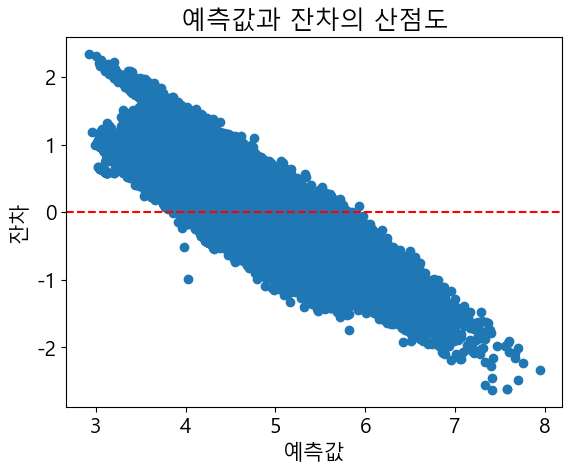

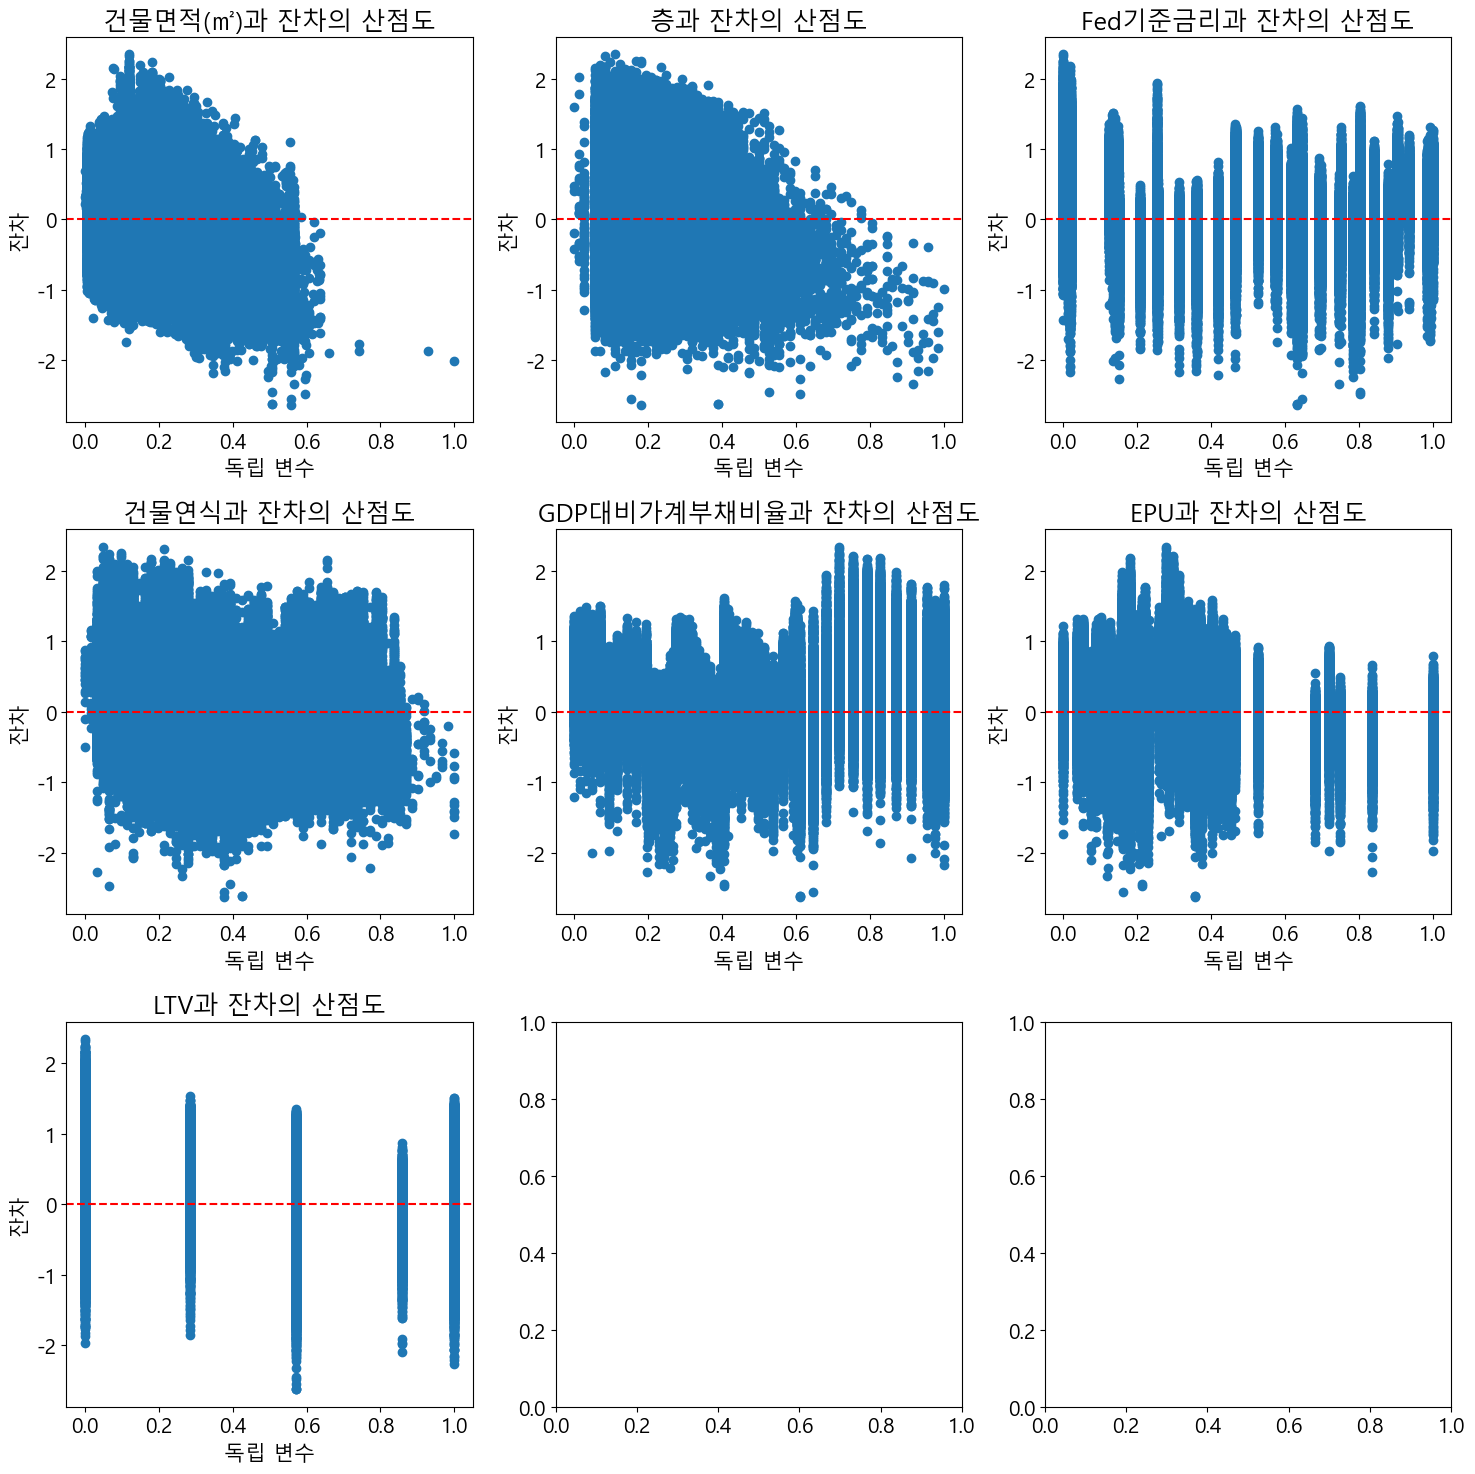

In [191]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math

x = X_scaled
y = y_scaled

# 모델 적합
model = sm.OLS(y, x)  # 종속 변수 y와 독립 변수 X를 지정하여 모델 생성
result = model.fit()  # 모델 적합

# 잔차 추출
residuals = result.resid

# 잔차 분석
# 잔차의 정규성 확인: 잔차의 분포를 정규분포와 비교하여 정규성 검정을 수행합니다.
sm.qqplot(residuals, line='s')  # Q-Q plot을 그려서 정규성 확인
plt.xlabel('이론적인 분위수')
plt.ylabel('잔차')
plt.title('잔차의 Q-Q 플롯')
plt.show()

# 잔차의 등분산성 확인: 잔차와 예측값 사이의 관계를 살펴서 등분산성을 확인합니다.
plt.scatter(result.fittedvalues, residuals)
plt.xlabel('예측값')
plt.ylabel('잔차')
plt.title('예측값과 잔차의 산점도')
plt.axhline(y=0, color='red', linestyle='--')  # 잔차가 0인 기준선 추가
plt.show()

# 잔차의 독립성 확인: 잔차와 독립 변수 간의 관계를 살펴서 독립성을 확인합니다.
num_cols = len(x.columns)
num_rows = math.ceil(num_cols / 3)  # 3개의 열로 나누어 출력하고자 한다면
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows*5))
for i in range(num_cols):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    ax.scatter(x.iloc[:, i], residuals)
    ax.set_xlabel('독립 변수')
    ax.set_ylabel('잔차')
    ax.set_title(f'{x.columns[i]}과 잔차의 산점도')
    ax.axhline(y=0, color='red', linestyle='--')  # 잔차가 0인 기준선 추가

plt.tight_layout()  # 그래프 간격 조정
plt.show()